#### To Do

1. Sanity check first [done]
1. Band power with respect to stimulus onset -> to check if LFP is properly aligned [done]
2. Calculate hidden state distribution for each stimulus
4. UMAP LFP inputs (should match the figure on the paper)
5. Calculate hidden state distributions with respect to hit and miss trials

#### Libraries and dependencies

In [1]:
import umap
import numpy as np
import pandas as pd
from hmmlearn import hmm
from tqdm import tqdm
from copy import deepcopy
from scipy.stats import zscore, mode, entropy
from matplotlib import pyplot as plt
from scipy.signal import butter, sosfiltfilt, filtfilt, hilbert, decimate
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
output_dir = "E:/jerry/vbn_s3_cache"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)
probes = cache.get_probe_table() # type: ignore

e:\jerry\anaconda\envs\allensdk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1064644573 day 1

In [2]:
session_id = probes.loc[1064735073]['ecephys_session_id']
session = cache.get_ecephys_session(ecephys_session_id=session_id) # type: ignore
probeA = session.get_lfp(1064735071) #VISam
"""probeB = session.get_lfp(1064735072) #VISpm
probeC = session.get_lfp(1064735073) #VISp
probeD = session.get_lfp(1064735075) #VISl
probeE = session.get_lfp(1064735076) #VISal
probeF = session.get_lfp(1064735077) #VISrl""";
chans = session.get_channels()

#### 1055403683 day2

In [2]:
session = cache.get_ecephys_session(ecephys_session_id=1055403683)
chans = session.get_channels()
probeA = session.get_lfp(1055529304) #VISam
probeB = session.get_lfp(1055529306) #VISpm
probeC = session.get_lfp(1055529307) #VISp
probeD = session.get_lfp(1055529308) #VISl
probeE = session.get_lfp(1055529309) #VISal
probeF = session.get_lfp(1055529310) #VISrl

In [20]:
# getting the start and end of stim block 0
stim_pre = session.stimulus_presentations
stim = stim_pre[stim_pre['stimulus_name'].str.contains('Natural')]
stim = stim[stim['stimulus_block'] == 0]
stim_times = stim.start_time.values # all the start times
stim_ids = stim.index.values # all the stimulus ids
start = stim.iloc[0].start_time
end = stim.iloc[-1].end_time
master_time = np.arange(start-0.25-0.08, end, 1/1250) # 250ms b4 start to end sliced by 0.8ms <- sampling rate of LFP; also 80ms before stim start to avoid edge effects
imgs = np.unique(stim['image_name'].values)

> Day 2: ['im005_r' 'im024_r' 'im034_r' 'im083_r' 'im087_r' 'im104_r' 'im111_r' 'im114_r' 'omitted']

In [21]:
img = imgs[3]
print(img)
stim_img = stim[stim['image_name'] == img]
stim_start = stim_img.start_time.values[:200]

im083_r


#### [Tutorial] Aligning LFP

In [40]:
def align_lfp(lfp, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    #print(time_selection)
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    return ds['aligned_lfp']

In [41]:
aligned_lfp = align_lfp(probeB, np.arange(-0.2, 0.2, 1/10), [stim_times[0]], [stim_ids[0]])

In [42]:
chans = session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]

chans_in_brain = chans[(chans['probe_id']==1064735073)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()
fig, ax = plt.subplots()
fig.suptitle('Flash aligned mean LFP')
im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')

NameError: name 'lfp' is not defined

#### Filtering

In [102]:
def find_nearest_idx(array, value):
    idxs = np.zeros(len(value), dtype=int)
    for i, v in enumerate(value):
        idx = np.argmin(np.abs(np.array(array) - v))
        idxs[i] = idx
    return idxs

In [22]:
lfpA_slice = probeA.sel(time=master_time, method='nearest')
lfpB_slice = probeB.sel(time=master_time, method='nearest')
lfpC_slice = probeC.sel(time=master_time, method='nearest')
lfpD_slice = probeD.sel(time=master_time, method='nearest')
lfpE_slice = probeE.sel(time=master_time, method='nearest')
lfpF_slice = probeF.sel(time=master_time, method='nearest')
lfpA_copy = deepcopy(lfpA_slice)
lfpB_copy = deepcopy(lfpB_slice)
lfpC_copy = deepcopy(lfpC_slice)
lfpD_copy = deepcopy(lfpD_slice)
lfpE_copy = deepcopy(lfpE_slice)
lfpF_copy = deepcopy(lfpF_slice)

In [8]:
def testing(probe, num):
    ac47 = probe[:,num]
    bands = np.zeros((4, 200, 1250))
    Wns = [[3,8],[10,30],[30,50],[50,80]]
    for i, Wn in enumerate(Wns):
        sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos')
        for j, start in enumerate(stim_start):
            test = ac47.sel(time=slice(start-0.25, start+0.75)).values
            test_ff = sosfiltfilt(sos, test) 
            test_env = hilbert(test_ff)
            test_env_abs = np.abs(test_env)
            if len(test_env_abs) < 1250:
                bands[i][j][:len(test_env_abs)] = zscore(test_env_abs**2)
                bands[i][j][len(test_env_abs):] = zscore(test_env_abs[-1]**2)
            elif len(test_env_abs) > 1250:
                bands[i][j] = zscore(test_env_abs[:1250]**2)
            else:
                bands[i][j] = zscore(test_env_abs**2)
    avg = np.mean(bands, axis=1)
    plt.plot(avg[0].T, label='3-8')
    plt.plot(avg[1].T, label='10-30')
    plt.plot(avg[2].T, label='30-50')
    plt.plot(avg[3].T, label='50-80')
    plt.axvline(250/0.8, c='r')
    plt.axvline(500/0.8, c='r')
    plt.legend();
    return avg

##### find nearest idx

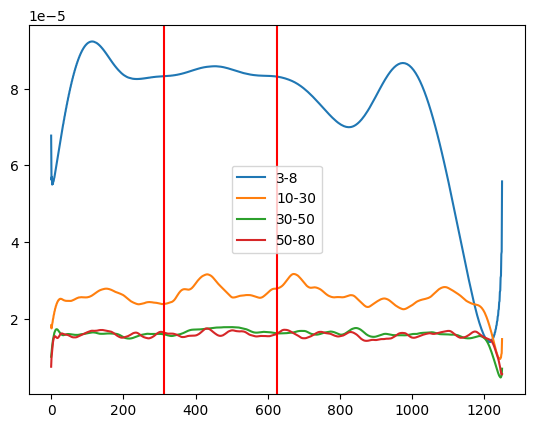

In [162]:
ac47=probeA[:,23]
bands = np.zeros((4, 200, 1250)) # 4 bands, 200 trials, 1250 time points
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, Wn in enumerate(Wns):
    sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos')
    for j, start in enumerate(stim_start):
        idx = np.arange(find_nearest_idx(ac47.time.values, start-0.25),find_nearest_idx(ac47.time.values, start+0.75))
        test = ac47.values[idx]
        test_ff = sosfiltfilt(sos, test) 
        test_env = hilbert(test_ff)
        test_env_abs = np.abs(test_env)
        if len(test_env_abs) < 1250:
            bands[i][j][:len(test_env_abs)] = test_env_abs
            bands[i][j][len(test_env_abs):] = test_env_abs[-1]
        elif len(test_env_abs) > 1250:
            bands[i][j] = test_env_abs[:1250]
        else:
            bands[i][j] = test_env_abs
avg = np.mean(bands, axis=1)
plt.plot(avg[0].T, label='3-8')
plt.plot(avg[1].T, label='10-30')
plt.plot(avg[2].T, label='30-50')
plt.plot(avg[3].T, label='50-80')
plt.axvline(250/0.8, c='r')
plt.axvline(500/0.8, c='r')
plt.legend()

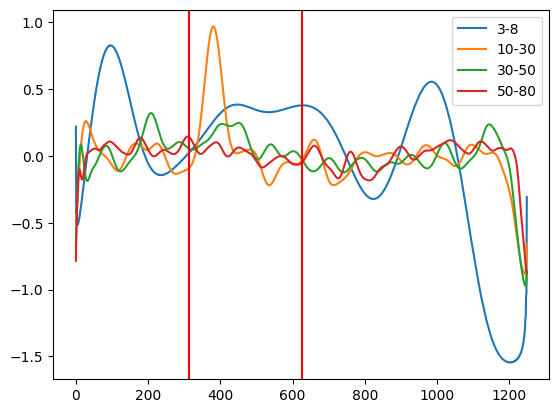

In [23]:
shared = testing(probeC, 23)

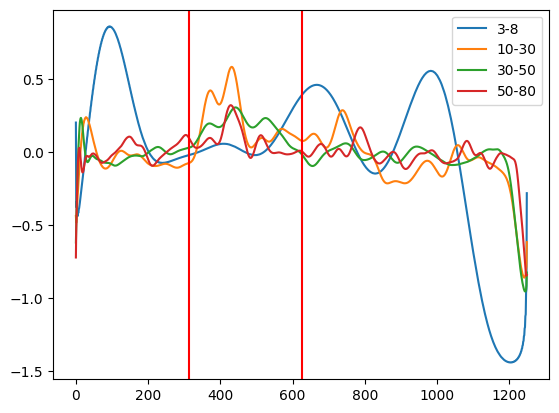

In [19]:
novel = testing(probeC, 23)

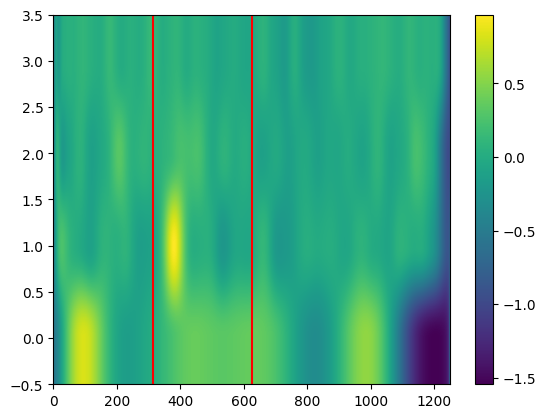

In [24]:
fig, ax = plt.subplots()
a = ax.imshow(shared, aspect='auto')
ax.axvline(250/0.8, c='r')
ax.axvline(500/0.8, c='r')
ax.invert_yaxis()
fig.colorbar(a)

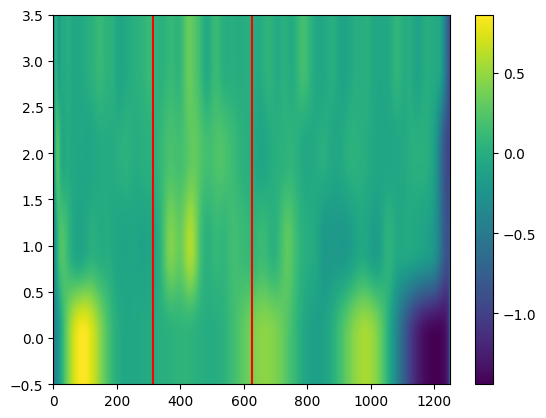

In [21]:
fig, ax = plt.subplots()
a = ax.imshow(novel, aspect='auto')
ax.axvline(250/0.8, c='r')
ax.axvline(500/0.8, c='r')
ax.invert_yaxis()
fig.colorbar(a)

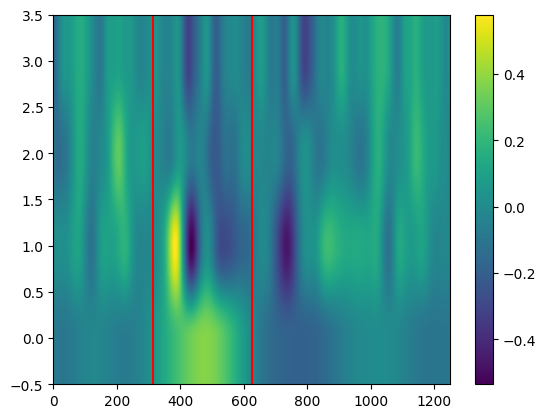

In [26]:
fig, ax = plt.subplots()
a = ax.imshow(shared-novel, aspect='auto')
ax.axvline(250/0.8, c='r')
ax.axvline(500/0.8, c='r')
ax.invert_yaxis()
fig.colorbar(a)

##### sel and slice

In [190]:
mask = np.array([23])
A_chan = lfpA_copy[:,mask]
B_chan = lfpB_copy[:,mask]
C_chan = lfpC_copy[:,mask]
D_chan = lfpD_copy[:,mask]
E_chan = lfpE_copy[:,mask]
F_chan = lfpF_copy[:,mask]

In [191]:
print(A_chan.shape == B_chan.shape == C_chan.shape == D_chan.shape == E_chan.shape == F_chan.shape) # should all be the same

True


#### GaussianHMM

In [276]:
# plotting state
def plot(preds, num=3):
    plt.plot(preds[int(250/4):int(750*num/4)])
    start_time = 80
    for i in range(num):
        plt.axvspan(start_time/4, (start_time+250)/4, alpha=0.2, color='red') # stimulus
        start_time += 250
        plt.axvspan(start_time/4, (start_time+500)/4, alpha=0.2, color='gray') # gray
        start_time += 500

In [ ]:
bands = np.zeros((4, 6, len(A_chan))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.hstack((A_chan, B_chan, C_chan, D_chan, E_chan, F_chan))
print(all_channels.shape)
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels.T) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    bands[i] = all_channels_env_abs
print(bands.shape)
#bands = np.reshape(bands,(4*18, len(A_chan)))
bands = np.reshape(bands,(4*6, len(A_chan)))
bands = bands[:,100:]
print(bands.shape)

In [72]:
find_nearest_idx(master_time,stim.iloc[0].start_time)-100

312

###### sanity checks

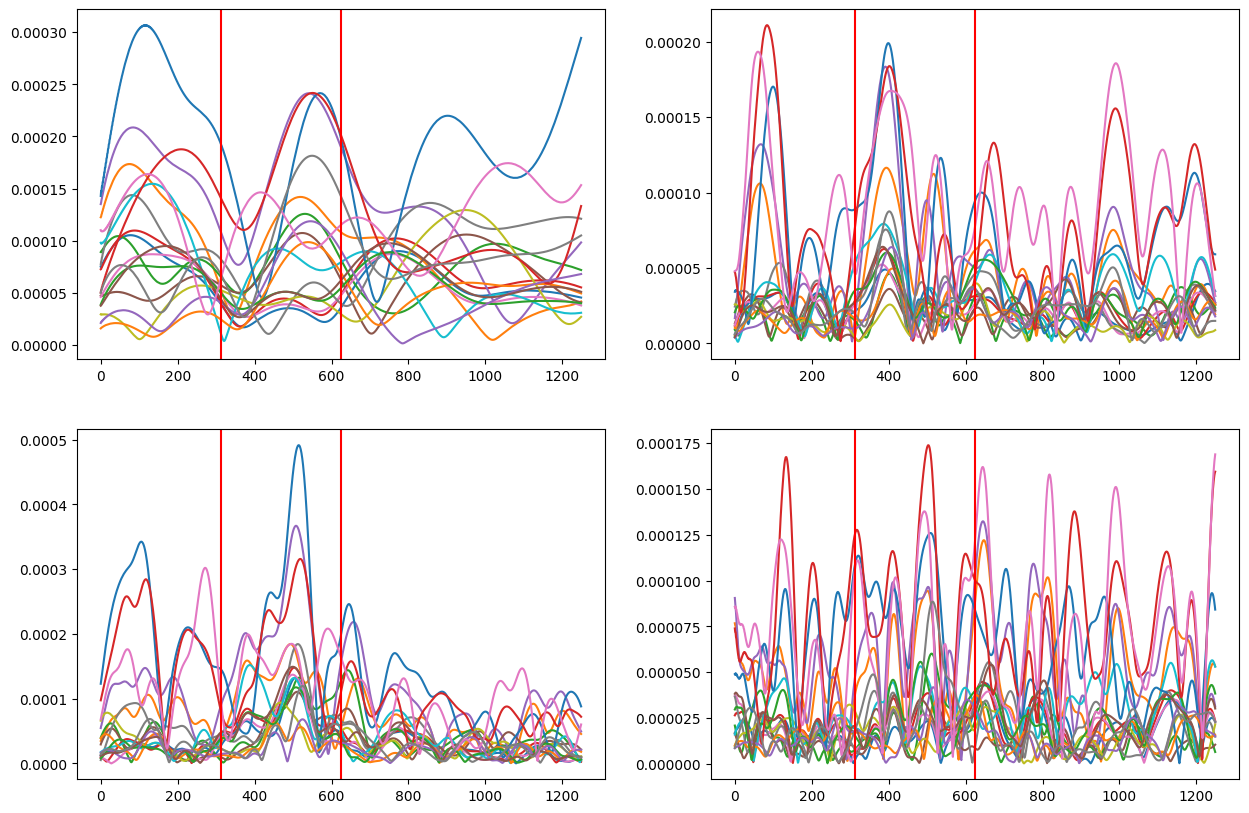

In [43]:
fig, axs=plt.subplots(2,2, figsize=(15,10))
for i in range(4):
    for j in range(18):
        axs[i%2][i//2].plot(bands[i*18+j].T[0:1250])
    axs[i%2][i//2].axvline(250/0.8, c='r')
    axs[i%2][i//2].axvline(500/0.8, c='r')

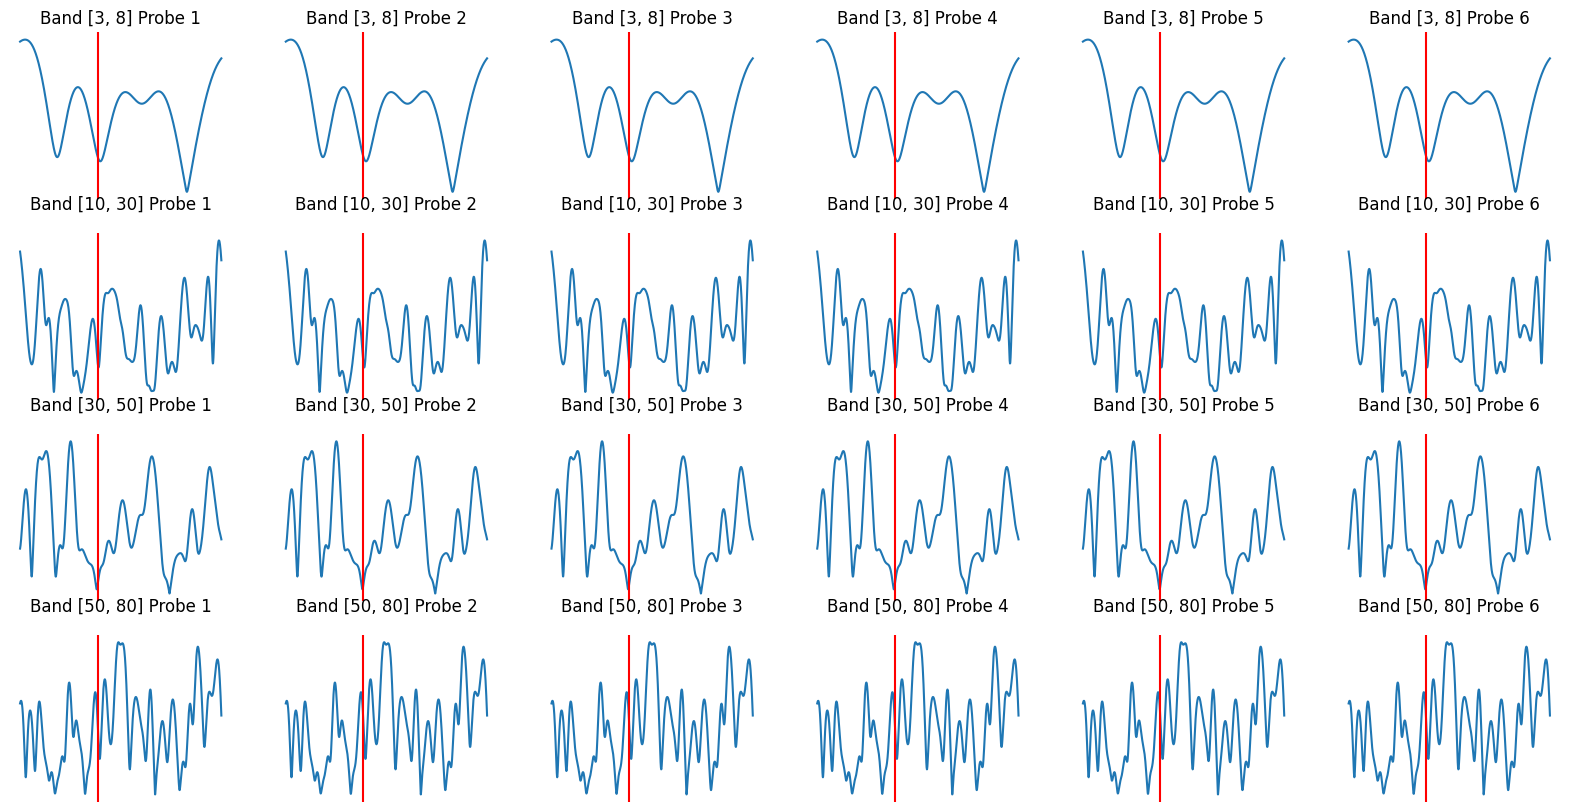

In [38]:
start = stim.iloc[3].start_time
near_idx = find_nearest_idx(probeC.time.values, [start]) # type: ignore
fig, axs = plt.subplots(4, 6, figsize=(20, 10))
for i in range(4):
    for j in range(6):
        axs[i, j].plot(bands[i, j].T[near_idx-500:near_idx+800])
        axs[i, j].axvline(500, c='r')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Band {Wns[i]} Probe {j+1}')


###### end

In [65]:
bands_z = zscore(bands, axis=1)
bands_z_0 = zscore(bands, axis=0)

In [156]:
model = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=1)
model.fit(bands_z_0.T)
preds = model.predict(bands_z_0.T)

         1 -171853631.79641736             +nan
         2 -154474355.49532196 +17379276.30109540
         3 -146532195.00029200 +7942160.49502996
         4 -145370531.64682013 +1161663.35347188
         5 -145025412.46595877 +345119.18086135
         6 -144867501.27213889 +157911.19381988
         7 -144771961.29978633  +95539.97235256
         8 -144703354.08393726  +68607.21584907
         9 -144650748.42406601  +52605.65987125
        10 -144610527.61439732  +40220.80966869
        11 -144579511.69449067  +31015.91990665
        12 -144556717.10008863  +22794.59440205
        13 -144540001.60939702  +16715.49069160
        14 -144528429.06698462  +11572.54241240
        15 -144520052.08965212   +8376.97733250
        16 -144514007.65873614   +6044.43091598
        17 -144509678.12957746   +4329.52915868
        18 -144506665.69983515   +3012.42974231
        19 -144504503.10628760   +2162.59354755
        20 -144502900.90760577   +1602.19868183
        21 -144501713.94617888   +11

In [163]:
m_t = master_time[100:] # to remove the 100 paddings
all_stims = np.unique(stim['image_name'].values)
u_mask = np.ones(len(m_t), dtype=int)
distribution=np.zeros((10,4))
for s_idx, s in tqdm(enumerate(all_stims)):
    stim_start = stim[stim['image_name'] == s].start_time.values
    stim_end = stim[stim['image_name'] == s].end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]

9it [05:30, 36.71s/it]


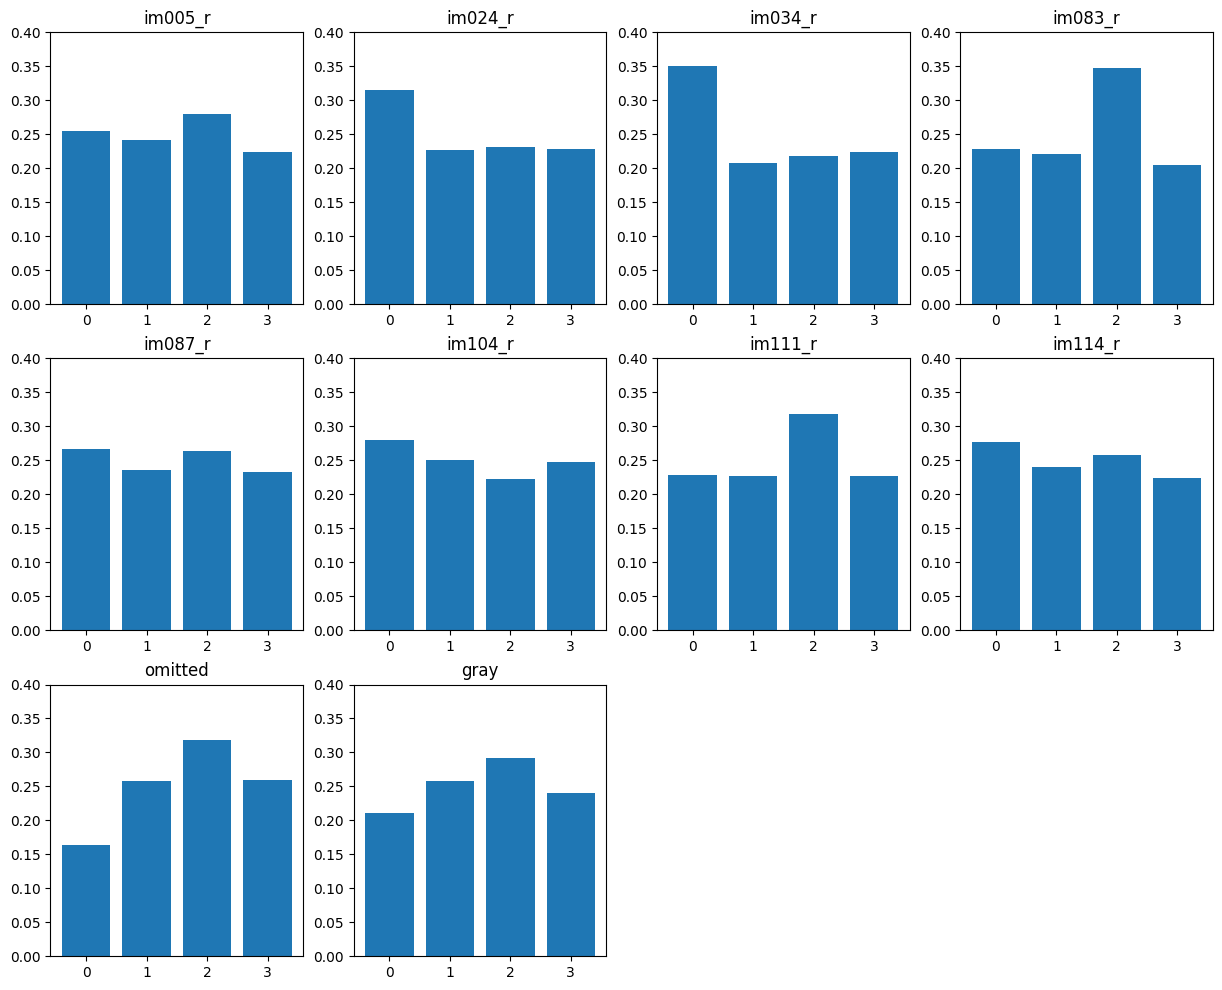

In [171]:
u_preds=preds[90:][u_mask==1]
unique, counts = np.unique(u_preds, return_counts=True)
for i, u in enumerate(unique):
    distribution[-1][u] += counts[i]
d = deepcopy(distribution)
for i in range(10):
    d[i] = d[i]/np.sum(d[i])
fig,axs = plt.subplots(3, 4, figsize=(15,12))
for i in range(3):
    for j in range(4):
        try:
            axs[i][j].bar(np.arange(4), d[i*4+j])
        except:
            axs[i][j].axis('off')
            continue
        try:
            axs[i][j].set_title(all_stims[i*4+j])
        except:
            axs[i][j].set_title('gray')
        axs[i][j].set_yticks(np.arange(0,0.41,0.05))        

In [178]:
entropies = np.zeros(10)
for i in range(len(d)):
    entropies[i] = entropy(d[i])

In [175]:
h_r_path = "E:/jerry/hit_rates/1055403683.npz"
np.load(h_r_path, allow_pickle=True)['h_r']

array([0.58333333, 0.71428571, 0.7027027 , 0.        , 0.79411765,
       0.82352941, 0.14285714, 0.88888889])

In [161]:
file_path="E:/jerry/temp/preds/4_1.npz"
np.savez(file_path, preds=preds)

In [173]:
file_path="E:/jerry/temp/distributions/4_1.npz"
np.savez(file_path, distribution=distribution)

In [ ]:
m_t = master_time[100:] # to remove the 100 paddings
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
all_stims = np.unique(stim['image_name'].values)
u_mask = np.ones(len(m_t), dtype=int)
distribution=np.zeros((10,8))
for s_idx, s in tqdm(enumerate(all_stims)):
    stim_start = stim[stim['image_name'] == s].start_time.values
    stim_end = stim[stim['image_name'] == s].end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
    #axs[s_idx//3][s_idx%3].bar(np.arange(8), zscore(distribution))
    #axs[s_idx//3][s_idx%3].set_title(s)

In [136]:
u_preds=preds[90:][u_mask==1]
unique, counts = np.unique(u_preds, return_counts=True)
for i, u in enumerate(unique):
    distribution[-1][u] += counts[i]
d = deepcopy(distribution)
for i in range(10):
    d[i] = d[i]/np.sum(d[i])
fig,axs = plt.subplots(3,4,figsize=(15,12))
for i in range(3):
    for j in range(4):
        try:
            axs[i][j].bar(np.arange(8), d[i*4+j])
        except:
            axs[i][j].axis('off')
            continue
        try:
            axs[i][j].set_title(all_stims[i*4+j])
        except:
            axs[i][j].set_title('gray')
        axs[i][j].set_yticks(np.arange(0,0.26,0.05))
        

In [145]:
d = deepcopy(distribution)
for i in range(10):
    d[i] = d[i]/np.sum(d[i])

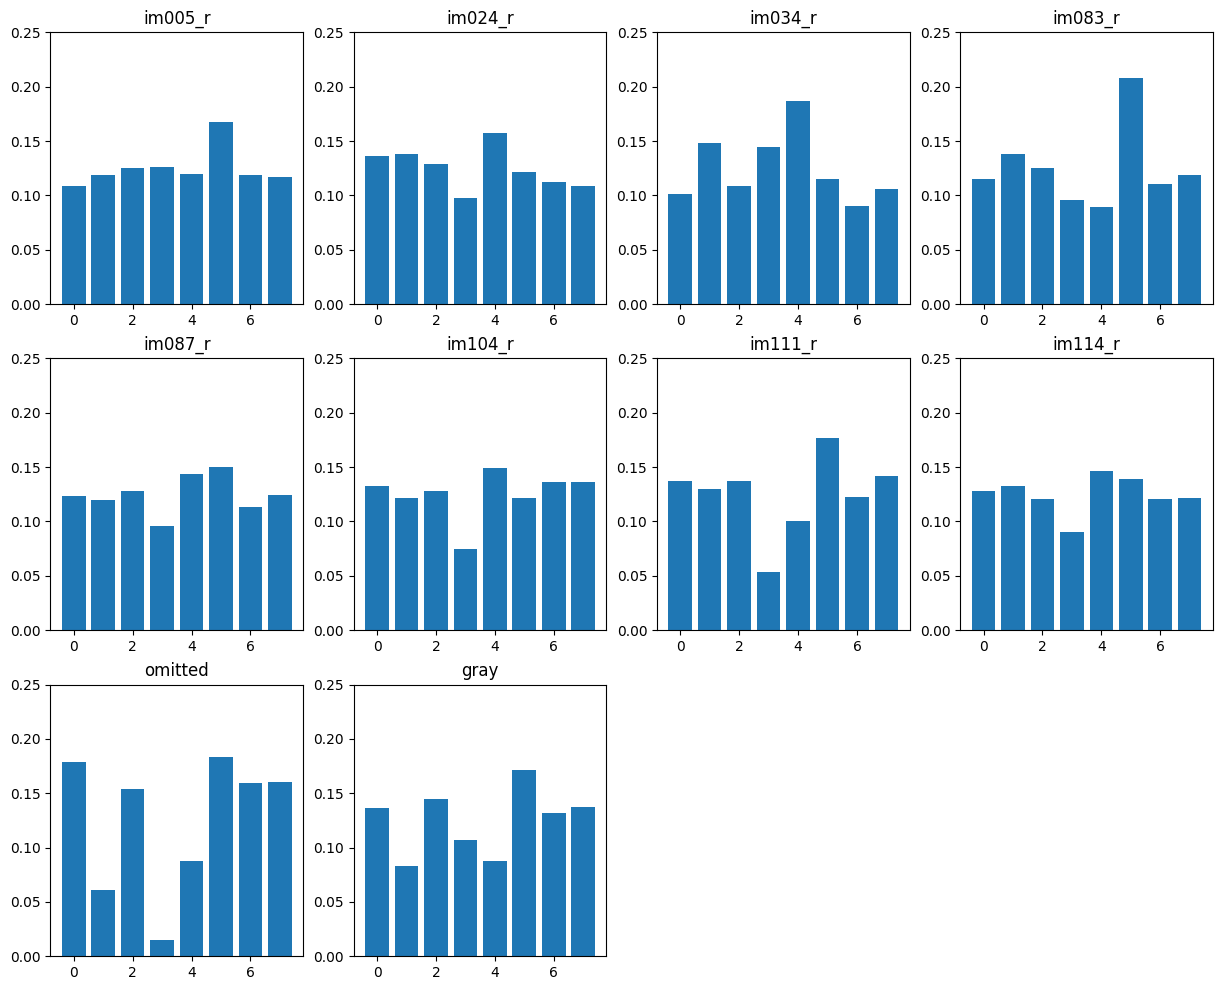

In [152]:
fig,axs = plt.subplots(3,4,figsize=(15,12))
for i in range(3):
    for j in range(4):
        try:
            axs[i][j].bar(np.arange(8), d[i*4+j])
        except:
            axs[i][j].axis('off')
            continue
        try:
            axs[i][j].set_title(all_stims[i*4+j])
        except:
            axs[i][j].set_title('gray')
        axs[i][j].set_yticks(np.arange(0,0.26,0.05))
        

#### downsampling

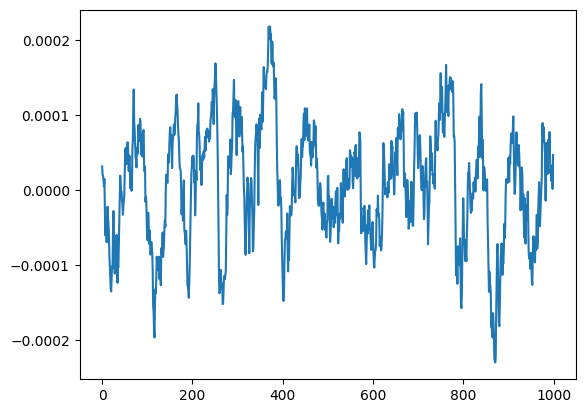

In [230]:
temp = np.reshape(A_chan, (1,-1))
A_chan_down = decimate(temp, 2)
plt.plot(A_chan_down[0][0:1000])

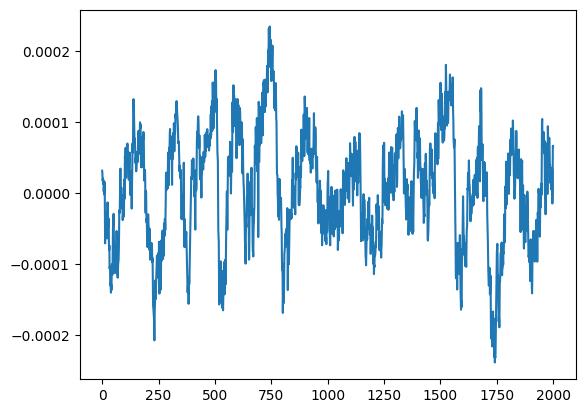

In [205]:
plt.plot(A_chan[0:2000])

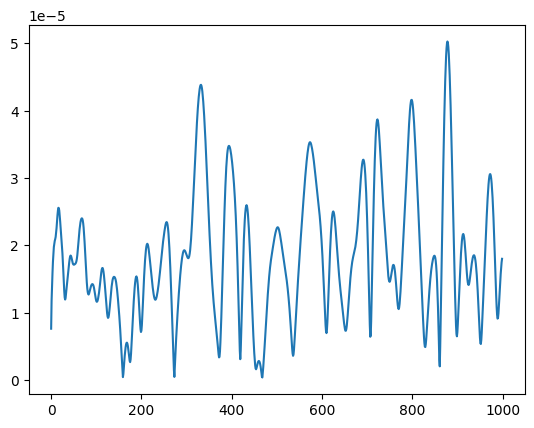

In [211]:
sos = butter(N=3, Wn=[50,80], fs=625, btype='bandpass', output='sos')
A_chan_ff = sosfiltfilt(sos, A_chan_down[0])
A_chan_env = hilbert(A_chan_ff)
A_chan_env_abs = np.abs(A_chan_env)
plt.plot(A_chan_env_abs[0:1000])

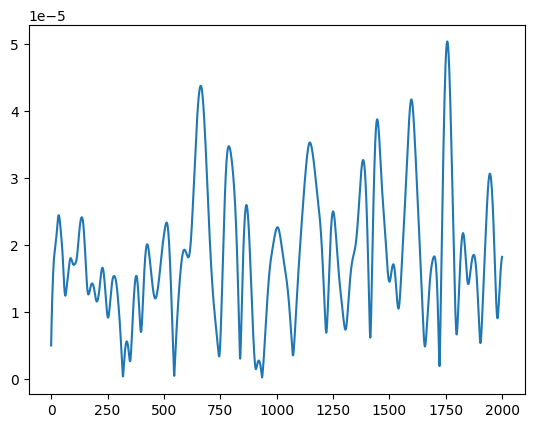

In [212]:
sos = butter(N=3, Wn=[50,80], fs=1250, btype='bandpass', output='sos')
A_chan_ff = sosfiltfilt(sos, A_chan[:,0])
A_chan_env = hilbert(A_chan_ff)
A_chan_env_abs = np.abs(A_chan_env)
plt.plot(A_chan_env_abs[0:2000])

In [216]:
A_chan_down = decimate(A_chan.T[0], 2, axis=0)
B_chan_down = decimate(B_chan.T[0], 2, axis=0)
C_chan_down = decimate(C_chan.T[0], 2, axis=0)
D_chan_down = decimate(D_chan.T[0], 2, axis=0)
E_chan_down = decimate(E_chan.T[0], 2, axis=0)
F_chan_down = decimate(F_chan.T[0], 2, axis=0)

In [221]:
print(A_chan_down.shape)

(2252152,)


In [222]:
bands = np.zeros((4, 6, len(A_chan_down))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.vstack((A_chan_down, B_chan_down, C_chan_down, D_chan_down, E_chan_down, F_chan_down))
print(all_channels.shape)
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=625, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    bands[i] = all_channels_env_abs
print(bands.shape)
bands = np.reshape(bands,(4*6, len(A_chan_down)))
bands = bands[:,100:]
print(bands.shape)
bands_z = zscore(bands, axis=1)
bands_z_0 = zscore(bands, axis=0)

(6, 2252152)
(4, 6, 2252152)
(24, 2252052)


In [231]:
bands_z = zscore(bands, axis=1)
bands_z_0 = zscore(bands, axis=0)

In [232]:
model = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=1)
model.fit(bands_z_0.T)
preds = model.predict(bands_z_0.T)

         1 -41206856.37537061             +nan
         2 -33106480.14702451 +8100376.22834609
         3 -31185640.34979964 +1920839.79722488
         4 -30687663.79522775 +497976.55457189
         5 -30397177.15759529 +290486.63763246
         6 -30213505.16384083 +183671.99375445
         7 -30124591.57924938  +88913.58459145
         8 -30088215.17257499  +36376.40667439
         9 -30073663.19506229  +14551.97751270
        10 -30067455.04956751   +6208.14549478
        11 -30064641.86176614   +2813.18780137
        12 -30063248.74514197   +1393.11662417
        13 -30062497.04777959    +751.69736239
        14 -30062072.29449535    +424.75328423
        15 -30061826.93134756    +245.36314779
        16 -30061681.58202077    +145.34932679
        17 -30061590.99826552     +90.58375525
        18 -30061531.40473909     +59.59352643
        19 -30061490.43005655     +40.97468254
        20 -30061461.15811455     +29.27194200
        21 -30061439.48195969     +21.67615486
        22 

In [233]:
print(master_time)

[  25.16450032   25.16530032   25.16610032 ... 3628.60530033 3628.60610033
 3628.60690033]


In [234]:
master_time = np.arange(start-0.25-0.08, end, 1/625) # 250ms b4 start to end sliced by 1.6ms <- sampling rate of LFP; also 80ms before stim start to avoid edge effects

In [235]:
m_t = master_time[50:] # to remove the 100 paddings
all_stims = np.unique(stim['image_name'].values)
u_mask = np.ones(len(m_t), dtype=int)
distribution=np.zeros((10,4))
for s_idx, s in tqdm(enumerate(all_stims)):
    stim_start = stim[stim['image_name'] == s].start_time.values
    stim_end = stim[stim['image_name'] == s].end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]

9it [02:39, 17.71s/it]


##### 5x downsample

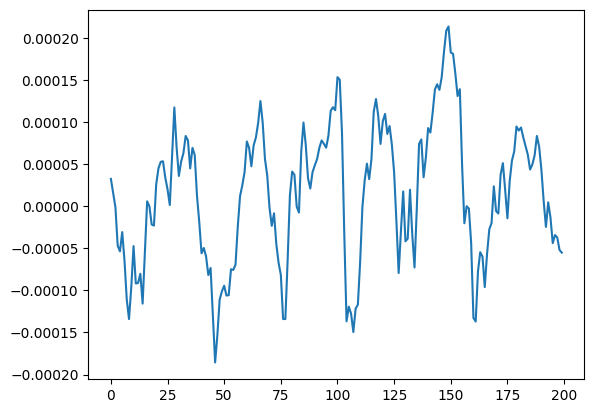

In [248]:
temp = np.reshape(A_chan, (1,-1))
A_chan_down = decimate(temp, 5)
plt.plot(A_chan_down[0][0:200])

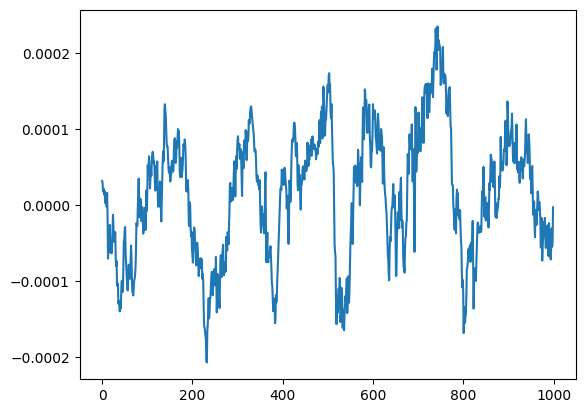

In [249]:
plt.plot(A_chan[0:1000])

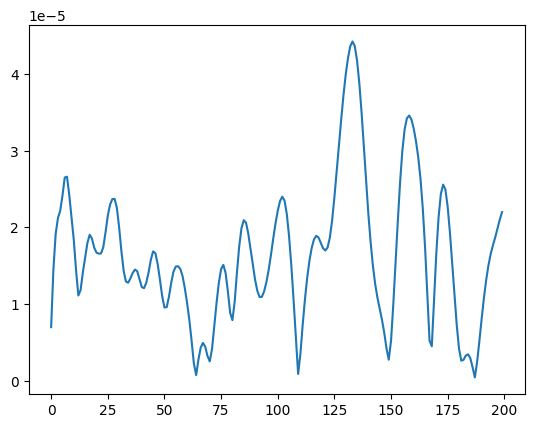

In [258]:
sos = butter(N=3, Wn=[50,80], fs=250, btype='bandpass', output='sos')
A_chan_ff = sosfiltfilt(sos, A_chan_down[0])
A_chan_env = hilbert(A_chan_ff)
A_chan_env_abs = np.abs(A_chan_env)
plt.plot(A_chan_env_abs[0:200])

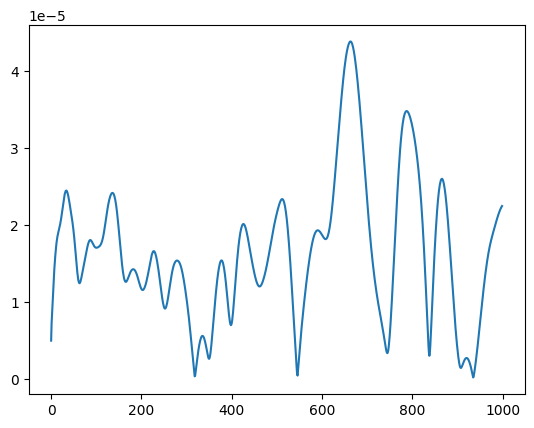

In [257]:
sos = butter(N=3, Wn=[50,80], fs=1250, btype='bandpass', output='sos')
A_chan_ff = sosfiltfilt(sos, A_chan.T[0])
A_chan_env = hilbert(A_chan_ff)
A_chan_env_abs = np.abs(A_chan_env)
plt.plot(A_chan_env_abs[0:1000])

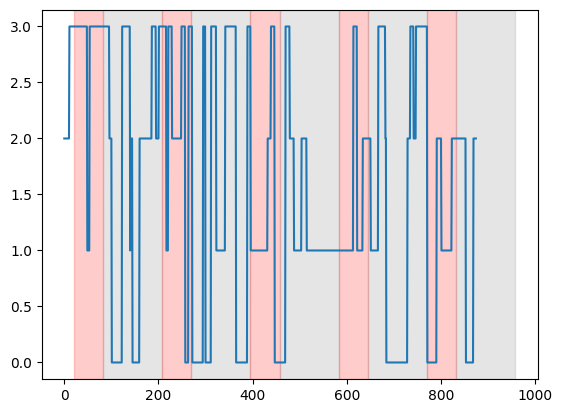

In [277]:
plot(preds,5)

In [259]:
A_chan_down = decimate(A_chan.T[0], 5, axis=0)
B_chan_down = decimate(B_chan.T[0], 5, axis=0)
C_chan_down = decimate(C_chan.T[0], 5, axis=0)
D_chan_down = decimate(D_chan.T[0], 5, axis=0)
E_chan_down = decimate(E_chan.T[0], 5, axis=0)
F_chan_down = decimate(F_chan.T[0], 5, axis=0)

In [260]:
bands = np.zeros((4, 6, len(A_chan_down))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.vstack((A_chan_down, B_chan_down, C_chan_down, D_chan_down, E_chan_down, F_chan_down))
print(all_channels.shape)
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    bands[i] = all_channels_env_abs
print(bands.shape)
bands = np.reshape(bands,(4*6, len(A_chan_down)))
bands = bands[:,100:]
print(bands.shape)
bands_z = zscore(bands, axis=1)
bands_z_0 = zscore(bands, axis=0)
print(bands_z.shape)
print(bands_z_0.shape)

(6, 900861)
(4, 6, 900861)
(24, 900761)
(24, 900761)
(24, 900761)


In [261]:
model = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=1)
model.fit(bands_z_0.T)
preds = model.predict(bands_z_0.T)

         1 -16945124.65673948             +nan
         2 -13721219.82195390 +3223904.83478558
         3 -12714850.61251080 +1006369.20944310
         4 -12458880.92056205 +255969.69194875
         5 -12372921.70813485  +85959.21242720
         6 -12338569.44436045  +34352.26377440
         7 -12318614.77775777  +19954.66660268
         8 -12298265.49630830  +20349.28144948
         9 -12268689.47686493  +29576.01944336
        10 -12223082.29940432  +45607.17746061
        11 -12167396.24245380  +55686.05695052
        12 -12123027.57252505  +44368.66992875
        13 -12097617.17667741  +25410.39584764
        14 -12084951.59039175  +12665.58628566
        15 -12078675.81794745   +6275.77244431
        16 -12075348.81711633   +3327.00083111
        17 -12073424.80874974   +1924.00836659
        18 -12072226.80953343   +1197.99921631
        19 -12071433.37297378    +793.43655966
        20 -12070880.07506039    +553.29791339
        21 -12070484.85038357    +395.22467682
        22 

In [262]:
master_time = np.arange(start-0.25-0.08, end, 1/250) # 250ms b4 start to end sliced by 4ms <- sampling rate of LFP; also 80ms before stim start to avoid edge effects

In [265]:
master_time.shape

(900861,)

In [263]:
bands.shape

(24, 900761)

In [264]:
preds.shape

(900761,)

In [266]:
m_t = master_time[100:]
all_stims = np.unique(stim['image_name'].values)
u_mask = np.ones(len(m_t), dtype=int)
distribution=np.zeros((10,4))
for s_idx, s in tqdm(enumerate(all_stims)):
    stim_start = stim[stim['image_name'] == s].start_time.values
    stim_end = stim[stim['image_name'] == s].end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]


9it [01:03,  7.07s/it]


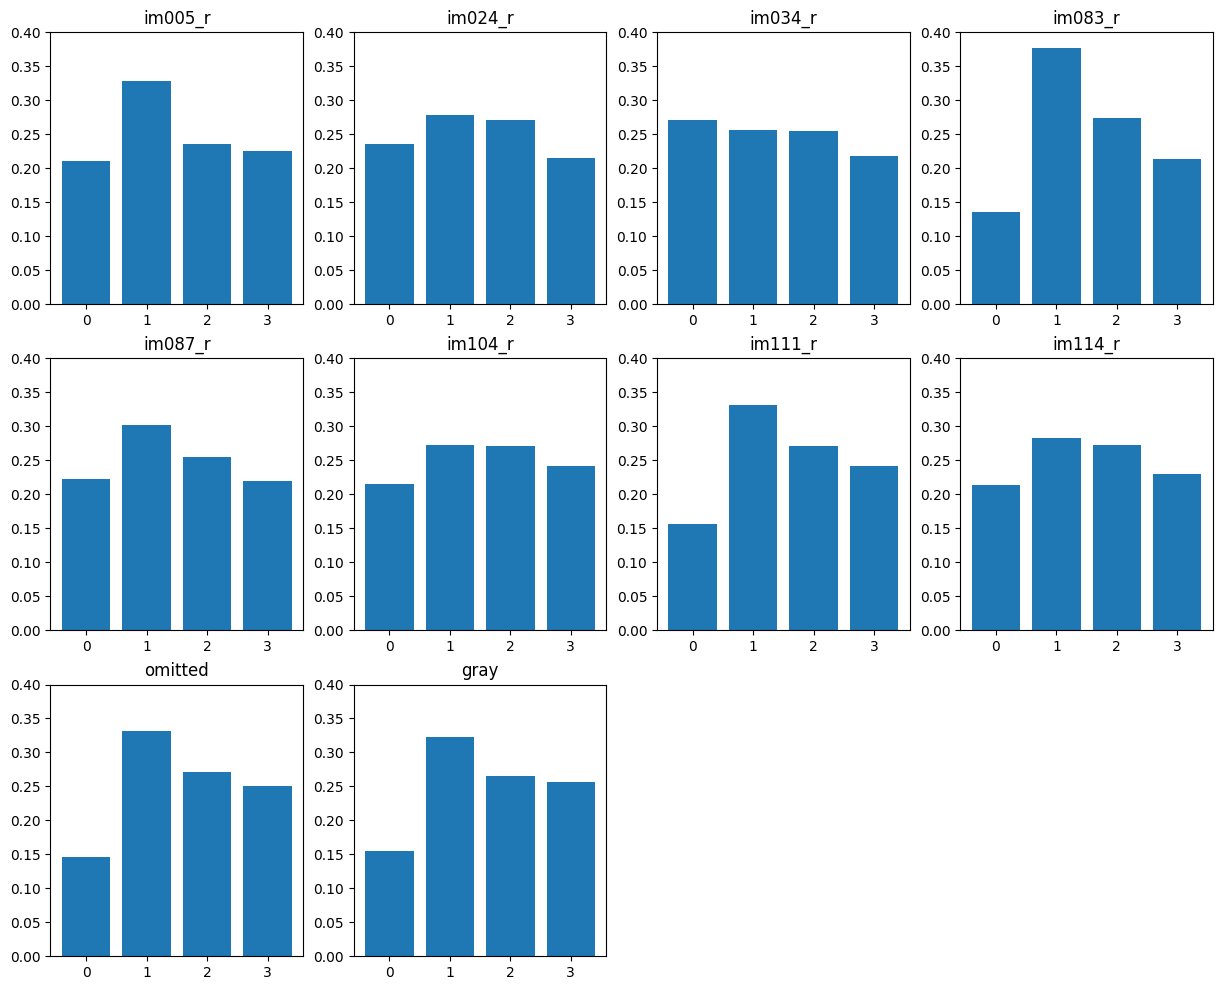

In [269]:
u_preds=preds[u_mask==1]
unique, counts = np.unique(u_preds, return_counts=True)
for i, u in enumerate(unique):
    distribution[-1][u] += counts[i]
d = deepcopy(distribution)
for i in range(10):
    d[i] = d[i]/np.sum(d[i])
fig,axs = plt.subplots(3,4,figsize=(15,12))
for i in range(3):
    for j in range(4):
        try:
            axs[i][j].bar(np.arange(4), d[i*4+j])
        except:
            axs[i][j].axis('off')
            continue
        try:
            axs[i][j].set_title(all_stims[i*4+j])
        except:
            axs[i][j].set_title('gray')
        axs[i][j].set_yticks(np.arange(0,0.41,0.05))
        

In [272]:
# getting the start and end of stim block 0
stim_pre = session.stimulus_presentations
stim = stim_pre[stim_pre['stimulus_name'].str.contains('Natural')]
stim = stim[stim['stimulus_block'] == 0]
stim_times = stim.start_time.values # all the start times
stim_ids = stim.index.values # all the stimulus ids
start = stim.iloc[0].start_time
end = stim.iloc[-1].end_time
master_time = np.arange(start-0.25-0.4, end, 1/250) # 250ms b4 start to end sliced by 4ms <- sampling rate of LFP; also 400ms before stim start to avoid edge effects
imgs = np.unique(stim['image_name'].values)
lfpA_slice = probeA.sel(time=master_time, method='nearest')
lfpB_slice = probeB.sel(time=master_time, method='nearest')
lfpC_slice = probeC.sel(time=master_time, method='nearest')
lfpD_slice = probeD.sel(time=master_time, method='nearest')
lfpE_slice = probeE.sel(time=master_time, method='nearest')
lfpF_slice = probeF.sel(time=master_time, method='nearest')
lfpA_copy = deepcopy(lfpA_slice)
lfpB_copy = deepcopy(lfpB_slice)
lfpC_copy = deepcopy(lfpC_slice)
lfpD_copy = deepcopy(lfpD_slice)
lfpE_copy = deepcopy(lfpE_slice)
lfpF_copy = deepcopy(lfpF_slice)

In [295]:
lfpA_copy.shape == lfpB_copy.shape == lfpC_copy.shape == lfpD_copy.shape == lfpE_copy.shape == lfpF_copy.shape

True

In [281]:
mask = np.array([23])
A_chan = lfpA_copy[:,mask].T[0]
B_chan = lfpB_copy[:,mask].T[0]
C_chan = lfpC_copy[:,mask].T[0]
D_chan = lfpD_copy[:,mask].T[0]
E_chan = lfpE_copy[:,mask].T[0]
F_chan = lfpF_copy[:,mask].T[0]

In [292]:
master_time.shape

(900941,)

In [296]:
bands = np.zeros((4, 6, len(A_chan))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.vstack((A_chan, B_chan, C_chan, D_chan, E_chan, F_chan))
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    bands[i] = all_channels_env_abs
bands = np.reshape(bands,(4*6, len(A_chan)))
print(bands.shape)
bands = bands[:,100:].T
bands_z = zscore(bands, axis=1)
bands_z_0 = zscore(bands, axis=0)
print(bands_z.shape)

(24, 900941)
(900841, 24)


In [311]:
np.mean(bands_z_0[:,0])

6.077829611077901e-16

In [297]:
model = hmm.GaussianHMM(n_components=6, n_iter=1000, verbose=True, tol=1)
model.fit(bands_z)
preds = model.predict(bands_z)

         1 -17404556.57626514             +nan
         2 -13036645.40683549 +4367911.16942965
         3 -12423829.75913774 +612815.64769774
         4 -12345852.12434520  +77977.63479254
         5 -12320119.67900643  +25732.44533877
         6 -12308946.05182927  +11173.62717717
         7 -12303163.04220588   +5783.00962339
         8 -12299751.84196905   +3411.20023683
         9 -12297522.79809698   +2229.04387206
        10 -12295918.32892793   +1604.46916905
        11 -12294647.43598677   +1270.89294116
        12 -12293500.24666488   +1147.18932190
        13 -12292413.77236417   +1086.47430070
        14 -12291361.60132928   +1052.17103489
        15 -12290280.94241445   +1080.65891483
        16 -12289099.82411715   +1181.11829729
        17 -12287703.93559186   +1395.88852529
        18 -12286038.78455327   +1665.15103859
        19 -12283945.86206629   +2092.92248698
        20 -12281356.38858274   +2589.47348355
        21 -12278335.33801635   +3021.05056640
        22 -

In [299]:
m_t = master_time[100:] # to remove the 100 paddings

(900941,)

In [302]:
m_t = master_time[100:]
all_stims = np.unique(stim['image_name'].values)
u_mask = np.ones(len(m_t), dtype=int)
distribution=np.zeros((10,6))
for s_idx, s in tqdm(enumerate(all_stims)):
    stim_start = stim[stim['image_name'] == s].start_time.values
    stim_end = stim[stim['image_name'] == s].end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
u_preds=preds[u_mask==1]
unique, counts = np.unique(u_preds, return_counts=True)
        

9it [01:03,  7.10s/it]


In [314]:
file_path="E:/jerry/temp/preds/6_1_5d_z.npz"
np.savez(file_path, preds=preds)
file_path="E:/jerry/temp/distributions/6_1_5d_z.npz"
np.savez(file_path, distribution=distribution)


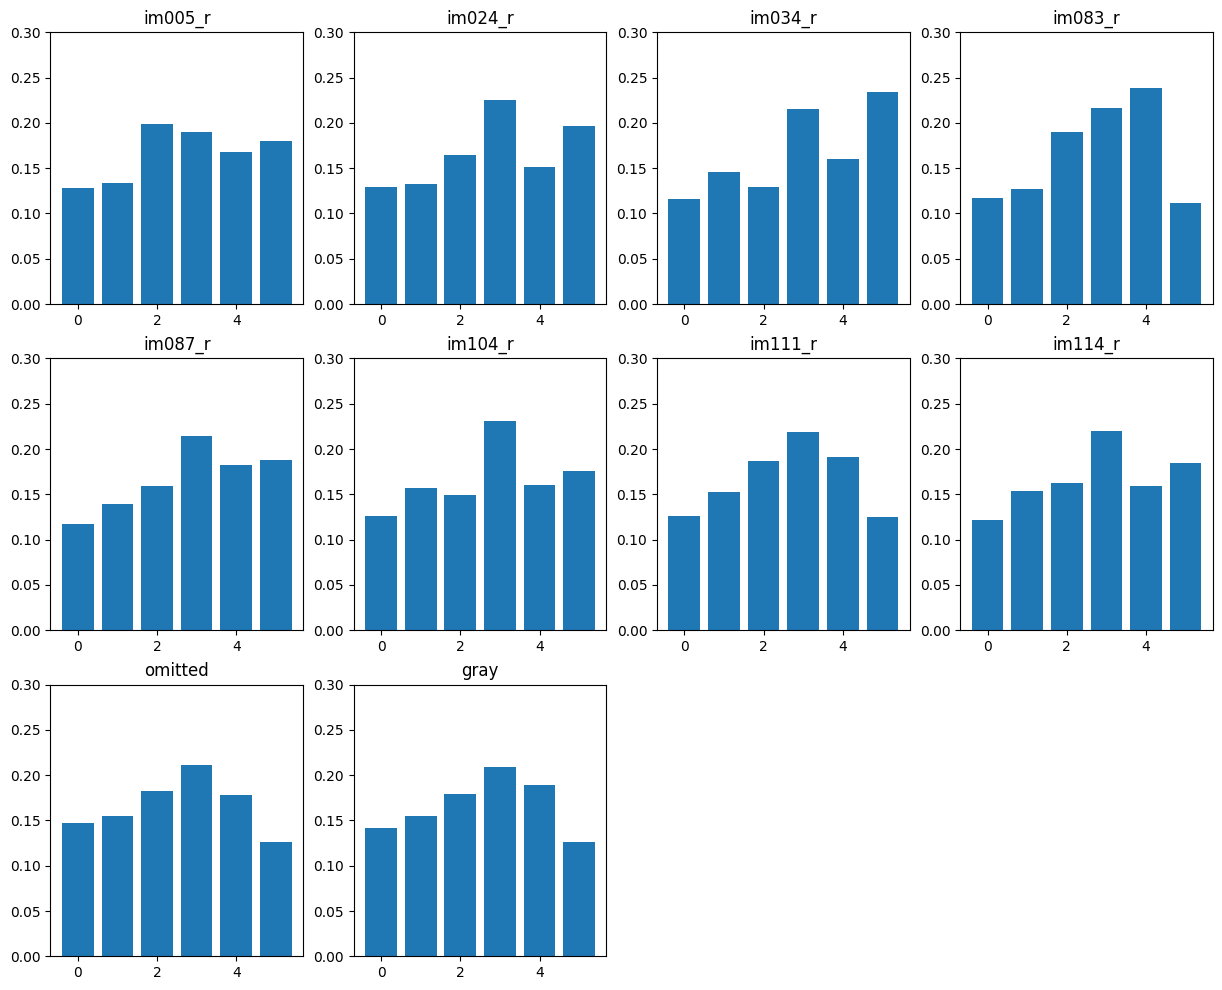

In [303]:
for i, u in enumerate(unique):
    distribution[-1][u] += counts[i]
d = deepcopy(distribution)
for i in range(10):
    d[i] = d[i]/np.sum(d[i])
fig,axs = plt.subplots(3, 4,figsize=(15,12))
for i in range(3):
    for j in range(4):
        try:
            axs[i][j].bar(np.arange(6), d[i*4+j])
        except:
            axs[i][j].axis('off')
            continue
        try:
            axs[i][j].set_title(all_stims[i*4+j])
        except:
            axs[i][j].set_title('gray')
        axs[i][j].set_yticks(np.arange(0,0.31,0.05))

In [312]:
model = hmm.GaussianHMM(n_components=6, n_iter=1000, verbose=True, tol=1)
model.fit(bands_z_0)
preds = model.predict(bands_z_0)

         1 -29864225.43601115             +nan
         2 -26616519.26253706 +3247706.17347409
         3 -26080811.74993639 +535707.51260067
         4 -25999154.53446591  +81657.21547049
         5 -25969764.98243345  +29389.55203245
         6 -25957186.40068572  +12578.58174773
         7 -25951257.46584202   +5928.93484370
         8 -25948064.95596519   +3192.50987682
         9 -25946111.01035380   +1953.94561139
        10 -25944781.57702428   +1329.43332952
        11 -25943799.42707980    +982.14994447
        12 -25942994.69702521    +804.73005459
        13 -25942329.09069883    +665.60632638
        14 -25941785.67594625    +543.41475258
        15 -25941329.17280088    +456.50314537
        16 -25940943.51354233    +385.65925856
        17 -25940616.68383995    +326.82970238
        18 -25940342.83477740    +273.84906255
        19 -25940120.25833813    +222.57643927
        20 -25939939.13276085    +181.12557728
        21 -25939788.93075705    +150.20200380
        22 -

In [ ]:
m_t = master_time[100:]
all_stims = np.unique(stim['image_name'].values)
u_mask = np.ones(len(m_t), dtype=int)
distribution=np.zeros((10,6))
for s_idx, s in tqdm(enumerate(all_stims)):
    stim_start = stim[stim['image_name'] == s].start_time.values
    stim_end = stim[stim['image_name'] == s].end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
u_preds=preds[u_mask==1]
unique, counts = np.unique(u_preds, return_counts=True)
        